# Causal Analysis of Symmetric Facts
We analyze where facts might be locateed in an LLM. A fact is represented by a tuple of subject, relation, object (s,r,o). We also investigate where an inverse fact mis located. An inverse fact is represented by the tuple (o, r^-1, s). For example, the fact "Paris is the capital of France" has the inverse fact "France's capital is France". 

## Setup

In [1]:
try:
    import google.colab
    IN_COLAB = True
    # %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
    renderer = "colab"
except:
    IN_COLAB = False
    from IPython import get_ipython
    %load_ext autoreload
    %autoreload 2
    renderer = "jupyterlab"

In [2]:
%%bash
cd ../
pip install poetry
poetry install
cd notebooks

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Using cached importlib_metadata-6.7.0-py3-none-any.whl (22 kB)
  Using cached platformdirs-3.10.0-py3-none-any.whl (17 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.8.0
    Uninstalling platformdirs-3.8.0:
      Successfully uninstalled platformdirs-3.8.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.2.0
    Uninstalling importlib-metadata-5.2.0:
      Successfully uninstalled importlib-metadata-5.2.0
Installing dependencies from lock file

Package operations: 0 installs, 3 updates, 0 removals

  • Updating importlib-metadata (6.7.0 -> 5.2.0)
  • Updating urllib3 (1.26.16 -> 2.0.3)
  • Updating p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
circuitsvis 1.40.0 requires importlib-metadata<6.0.0,>=5.1.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.7.0 which is incompatible.
sagemaker 2.167.0 requires protobuf<4.0,>=3.1, but you have protobuf 4.23.3 which is incompatible.


In [3]:

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = renderer

In [4]:
# Import stuff
import types
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [5]:
import ast
import pandas as pd

In [6]:
if IN_COLAB: 
    import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens.utilities import devices
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [8]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def cuda():
    return torch.cuda.is_available()

def get_device(): 
    return "cuda" if cuda() else "cpu"
device = get_device()
device


'cuda'

## Model

- fold_ln: Whether to fold in the LayerNorm weights to the subsequent linear layer. This does not change the computation.
- center_writing_weights: Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNormthis doesn't change the computation.
- center_unembed : Whether to center W_U (ie set mean to be zero). Softmax is translation invariant so this doesn't affect log probs or loss, but does change logits. Defaults to True.
- refactor_factored_attn_matrices: Whether to convert the factoredmatrices (W_Q & W_K, and W_O & W_V) to be "even". 

In [9]:
MODEL_NAME = "gpt2-large"

In [10]:
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    center_unembed=True,  
    center_writing_weights=True,              # Whether to center weights writing to the residual stream (ie set mean to be zero). Due to LayerNorm this doesn't change the computation.      
    fold_ln=True,                             # Whether to  fold in the LayerNorm weights to the subsequent linear layer.
    refactor_factored_attn_matrices=True,
)


 

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Dataset

In [11]:
import requests
import json

url = "https://rome.baulab.info/data/dsets/counterfact.json"

# Fetch the JSON data from the URL
response = requests.get(url)
data = response.json()


In [12]:
data[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [13]:
def noise_ablation(sample, n_noise_samples=5, vx=3):
    prompt = sample["requested_rewrite"]["prompt"]
    subject = sample["requested_rewrite"]["subject"]
    target = sample["requested_rewrite"]["target_true"]["str"]
    
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    target = "Paris"

    subject_tokens = model.to_tokens(subject)
    
    #shape: batch, n_tokens, embedding_dim
    subject_embedding = model.embed(subject_tokens)
    _, n_tokens, embedding_dim = subject_embedding.shape
    
    #noise: N(0,v), v = 3*std(embedding)
    embedding = model.W_E
    v = vx*torch.std(embedding, dim=0) #for each v in V
    noise = torch.randn(
        (n_noise_samples, n_tokens, embedding_dim)
    ).to(device) + v
    
    subject_embedding_w_noise = subject_embedding + noise
    
    #shape: batch, n_tokens, vocab_size (logits)
    unembedded_subject = model.unembed(subject_embedding_w_noise)

    noisy_subject_tokens = torch.argmax(unembedded_subject, dim=-1)
    noisy_subject_str = [
        model.to_string(nst) for nst in noisy_subject_tokens
    ]
    true_prompt = prompt.format(subject)
    corrupted_prompts = [
        prompt.format(nss) for nss in noisy_subject_str
    ]
    return true_prompt, corrupted_prompts, target

    
    
    
    
    

In [14]:
noise_ablation(data[0])

('The Eiffel Tower is located in',
 ['The  wearingSM STAND Ryu pressed is located in',
  'The angForwardthouse Swiftuder is located in',
  'The  vagburgh intrusionorumgate is located in',
  'The essenements Giul ¯Shape is located in',
  'The  waveHERivery simulricks is located in'],
 'Paris')

In [15]:
def resample_ablation(sample, n_noise_samples=20):
    prompt = sample["requested_rewrite"]["prompt"]
    subject = sample["requested_rewrite"]["subject"]
    target = sample["requested_rewrite"]["target_true"]["str"]
    
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    target = "Paris"
    
    
    subject_tokens = model.to_tokens(subject)
    
    embedding = model.W_E
    #we select n random rows from the embedding matrix
    permutations = torch.randperm(embedding.size(0))[:n_noise_samples]
    random_samples = embedding[permutations]
    #unsqueeze a token dimension between batch and embedding dims
    random_samples = random_samples.unsqueeze(dim=1)
    #we de-embed these rows
    random_embeddings = model.unembed(random_samples)
    random_tokens = torch.argmax(random_embeddings, dim=-1)
    random_subject_str = [
        model.to_string(t) for t in random_tokens
    ]
    corrupted_facts = [
        prompt.format(s) for s in random_subject_str
    ]
    true_fact = prompt.format(subject)
    return true_fact, corrupted_facts, target
    

    
    

In [16]:
resample_ablation(data[0], n_noise_samples=5)

('The Eiffel Tower is located in',
 ['The  Kod is located in',
  'The  inevitably is located in',
  'The  blows is located in',
  'The  armored is located in',
  'The coat is located in'],
 'Paris')

In [17]:
def pad_from_left(tokens : torch.tensor, maxlen:int):
    pad_token = model.tokenizer.pad_token_id
    padded_tokenized_inputs = torch.zeros(tokens.shape[0], maxlen)
    
    n_pads = maxlen - tokens.shape[-1]
    padded_tokenized_inputs[:,n_pads] = pad_token
    padded_tokenized_inputs[:,n_pads:] = tokens
    return padded_tokenized_inputs.long()

def pad_to_same_length(clean_tokens, corrupted_tokens): 
    
    maxlen = max([clean_tokens.shape[-1], corrupted_tokens.shape[-1]])
    
    if clean_tokens.shape[-1] > corrupted_tokens.shape[-1]: 
        corrupted_tokens = pad_from_left(corrupted_tokens, maxlen)
    elif clean_tokens.shape[-1] < corrupted_tokens.shape[-1]: 
        clean_tokens = pad_from_left(clean_tokens, maxlen)
    return clean_tokens, corrupted_tokens

In [18]:

def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    cache):
    corrupted_residual_component[:, pos, :] = cache[hook.name][:, pos, :]
    """
    Restore a patch in clean run. 
    """
    return corrupted_residual_component
    
    
def total_effect_causal_tracing_w_ablation(
                             clean_prompt: str,
                             corrupted_prompts: List[str],
                             target: str, 
                             corrupted_ablation=True, 
                             run="all"):
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    target_token_idx = model.to_tokens(target)[:,1:] #remember to slice out the start pad token
        
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")

    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
    
    #get the logits on the final token
    final_token_logits = final_token_logits[:,-1,:] #shape: batch, vocab_size
    #get the mean logit across the vocabulary
    u_pi = final_token_logits.mean(dim=1, keepdim=True)
    #get the logit for maximum likelihood token
    mle_token_idx = torch.argmax(final_token_logits, dim=-1).unsqueeze(-1)
    mle_token_logit = final_token_logits.gather(dim=-1, index=mle_token_idx)
    #also get the logit for the target token
    target_token_logit = final_token_logits.gather(dim=-1, index=target_token_idx)
    
    #center the logit for the target and mle tokens
    target_logit_centered_reference = target_token_logit - u_pi #shape: batch, n_tokens (generally=1)
    mle_logit_centered_reference = mle_token_logit - u_pi
    
        
    mle_total_effect_residuals = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    mle_total_effect_mlp = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    mle_total_effect_attn = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_residuals = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_mlp = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)
    target_total_effect_attn = torch.zeros(model.cfg.n_layers,
                                         clean_tokens.shape[-1], device=device, dtype=torch.float32)

    if corrupted_ablation: 
        input_tokens = clean_tokens
        restore_cache = corrupted_cache
    else: 
        input_tokens = corrupted_tokens
        restore_cache = clean_cache
        
    for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[-1]):
            #we do a clean run and get logit. We do a corrupted run and restore a clean 
            #activation. total effect is corrupted_logits_w_clean_patch - clean_logit. 
            #if the patch did not contribute, we get the original logits -> no effect
            
            if run=="residual" or run=="all":
                #Patch activations in the residual stream at token position and layer. 
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                #shape: batch, n_tokens, vocab_size
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("resid_pre", layer),hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                resid_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                resid_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_residuals[layer, position] = resid_total_effect_on_mle_logit.mean()
                target_total_effect_residuals[layer, position] = resid_total_effect_on_target_logit.mean()

            if run==["attn"] or run== "all":
                #Patch activations in attention layers
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("attn_out", layer), hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                attn_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                attn_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_attn[layer, position] = attn_total_effect_on_mle_logit.mean()
                target_total_effect_attn[layer, position] = attn_total_effect_on_target_logit.mean()
                
            if run=="mlp" or run=="all":
                #Patch activations in MLP layers
                hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
                patched_logits = model.run_with_hooks(
                    input_tokens,
                    fwd_hooks = [(utils.get_act_name("mlp_out", layer), hook_fn)],
                    return_type="logits"
                )
                patched_logits = patched_logits[:,-1,:] #get logit of last token (shape: batch, vocab)
                u_pi = patched_logits.mean(dim=1, keepdim=True)
                mle_token_logit = patched_logits.gather(dim=-1, index=mle_token_idx)
                target_token_logit = patched_logits.gather(dim=-1, index=target_token_idx)
                target_logit_centered = target_token_logit - u_pi
                mle_logit_centered = mle_token_logit - u_pi

                mlp_total_effect_on_target_logit = target_logit_centered - target_logit_centered_reference #batch x 1
                mlp_total_effect_on_mle_logit = mle_logit_centered - mle_logit_centered_reference #batch x 1
                
                mle_total_effect_mlp[layer, position] = mlp_total_effect_on_mle_logit.mean()
                target_total_effect_mlp[layer, position] = mlp_total_effect_on_target_logit.mean()


            
    return (
        mle_total_effect_residuals, 
        mle_total_effect_attn, 
        mle_total_effect_mlp, 
        target_total_effect_residuals, 
        target_total_effect_attn, 
        target_total_effect_mlp,      
    )

            
    
    

In [19]:
true_fact, corrupted_facts, target = resample_ablation(data[0], n_noise_samples=3)
retval = total_effect_causal_tracing_w_ablation(
    clean_prompt=true_fact, 
    corrupted_prompts=corrupted_facts, 
    target=target, 
    corrupted_ablation=True,
    run="mlp"
)

In [20]:
(mle_total_effect_residuals, 
mle_total_effect_attn, 
mle_total_effect_mlp, 
target_total_effect_residuals, 
target_total_effect_attn, 
target_total_effect_mlp) = retval

In [21]:


def plot_total_effect(total_effect, sample):
    prompt = sample["requested_rewrite"]["prompt"]
    subject = sample["requested_rewrite"]["subject"]
    prompt = "The {} is located in"
    subject = "Eiffel Tower"
    
    x = model.to_str_tokens(prompt.format(subject))
    
    imshow(total_effect, x=x,
           title="blah",labels={"x":"Position", "y":"Layer"})


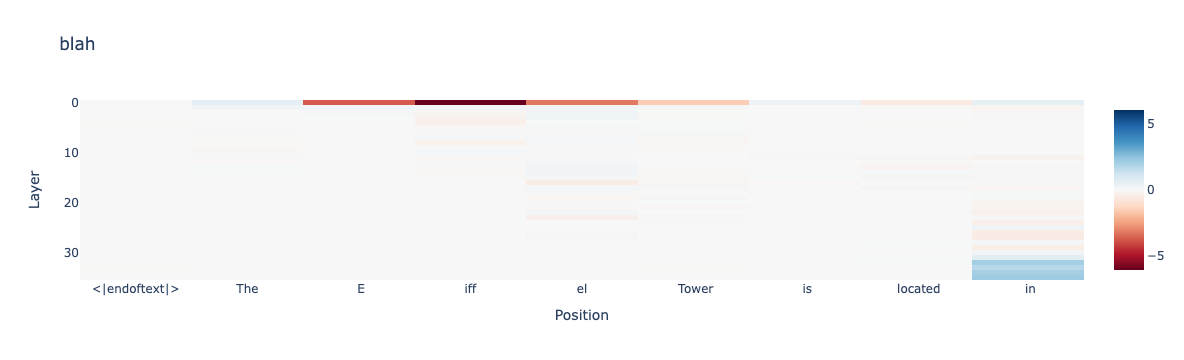

In [22]:
plot_total_effect(target_total_effect_mlp, data[0])

In [23]:
target_total_effect_residuals.shape

torch.Size([36, 9])

In [24]:
target_total_effect_mlp.shape

torch.Size([36, 9])

In [25]:

def get_direct_effect(clean_cache, corrupt_cache): 
    """
    TODO: check this param: 
    mlp_input (bool, optional): Whether to include attn_out for the current
                layer - essentially decomposing the residual stream that's input to the MLP input rather than the Attn input.
    """
    #residual shape: [74, 5, 1280] = n_layers, prompt, d_model
    residual_clean = clean_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "all",
                                     return_labels=False)
    #[74, 5, 10, 50257] = n_layers, prompt, tokens, vocab_size
    redidual_clean = unembedding_function(residual_clean, clean_cache, mlp=False)
    residual_clean = torch.argmax(residual_clean, dim=-1)
    
    #[38, 5, 10, 1280]
    residual_mlp_clean = clean_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "mlp",
                                     return_labels=False)
    #[38, 5, 50257]
    residual_mlp_clean = unembedding_function(residual_mlp_clean, clean_cache, mlp=True)
    residual_mlp_clean = torch.argmax(residual_mlp_clean, dim=-1)
    
    
    residual_attn_clean = clean_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "attn",
                                     return_labels=False)
    #[38, 5, 50257]
    residual_attn_clean = unembedding_function(residual_attn_clean, clean_cache, mlp=False)
    residual_attn_clean = torch.argmax(residual_attn_clean, dim=-1)
    
    
    residual_corrupt = corrupt_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "all",
                                     return_labels=False)
    residual_corrupt = unembedding_function(residual_corrupt, corrupt_cache, mlp=False)
    residual_corrupt = torch.argmax(residual_corrupt, dim=-1)
    
    residual_mlp_corrupt = corrupt_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "mlp",
                                     return_labels=False)
    residual_mlp_corrupt = unembedding_function(residual_mlp_corrupt, corrupt_cache, mlp=True)
    residual_mlp_corrupt = torch.argmax(residual_mlp_corrupt, dim=-1)
    residual_attn_corrupt = corrupt_cache.decompose_resid(layer=-1,
                                     mlp_input = False,
                                     mode = "attn",
                                     return_labels=False)
    residual_attn_corrupt = unembedding_function(residual_attn_corrupt, corrupt_cache, mlp=False)
    # n_layers x prompts
    residual_attn_corrupt = torch.argmax(residual_attn_corrupt, dim=-1)  
    
    #direct effects
    direct_effect_residual = residual_corrupt - residual_clean
    direct_effect_mlp = residual_mlp_corrupt - residual_mlp_clean
    direct_effect_attn = residual_attn_corrupt - residual_attn_clean
    return (direct_effect_residual, 
            direct_effect_attn, 
            direct_effect_mlp)

In [37]:
def unembedding_function(residual_stack, cache, mlp=False) -> float:
    #we are only interested in applying the layer norm of the final layer on the final token
    #shape: [74, 5, 10, 1280] = n_layers, prompts, tokens, d_model
    z = cache.apply_ln_to_stack(residual_stack, layer = -1, mlp_input=mlp)
    z = z @ model.W_U
    return z

def direct_effect(clean_cache,
                  corrupted_cache,
                  mle_token_idx,
                  target_token_idx, 
                  mode, 
                  mlp_input): 
    
    residual_clean_stack = clean_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
    residual_corrupted_stack = corrupted_cache.decompose_resid(layer=-1, mlp_input=mlp_input, mode=mode, return_labels=False)
    
    #shape: [74, 4, 9, 50257] = n_layers, batch, tokens, vocab_size
    residual_clean_logits = unembedding_function(residual_clean_stack, clean_cache)
    residual_clean_logits = residual_clean_logits[:,:,-1,:]
    
    residual_corrupted_logits = unembedding_function(residual_corrupted_stack, corrupted_cache)
    residual_corrupted_logits = residual_corrupted_logits[:,:,-1,:] #get for final token only
    
    target_residual_corrupted_logits = residual_corrupted_logits.gather(dim=-1, index=target_token_idx.unsqueeze(0))
    target_residual_corrupted_logits = residual_corrupted_logits.gather(dim=-1, index=mle_token_idx.unsqueeze(0))
    residual_clean_logits.gather(dim=-1, index=target_token_idx.unsqueeze(0))
    residual_clean_logits.gather(dim=-1, index=mle_token_idx.unsqueeze(0))
    
    print(target_residual_corrupted_logits)
    print(mle_residual_corrupted_logits)
    
    
    
    
def delta_direct_effect(clean_prompt: str,
                         corrupted_prompts: List[str],
                         target: str, 
                         corrupted_ablation=True, 
                         run="all"):
    
    clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True) 
    corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
    target_token_idx = model.to_tokens(target)[:,1:] #remember to slice out the start pad token
        
    #we pad the clean and corrupted tokens to the same length (pad from left)
    clean_tokens, corrupted_tokens = pad_to_same_length(clean_tokens, corrupted_tokens)
    #repeat clean_tokens to match corrupted_tokens
    clean_tokens = clean_tokens.expand(corrupted_tokens.shape[0], -1)
    target_token_idx = target_token_idx.expand(corrupted_tokens.shape[0], -1)

    
    #run the model on the clean and corrupted tokens, saving the model states for each
    #logits_shape: batch, n_tokens, vocab
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, return_type="logits")
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type="logits")
    
    direct_effect(clean_cache, corrupted_cache, target_token_idx, target_token_idx, mode="all", mlp_input=False)
    

    #to obtain the total effect, we need to get π(xt) - mean(πi for all i in V)
    #that is the logits of the last token from which we subtract the mean logits over all the vocab
    if corrupted_ablation: 
        #shape: noise_batch, n_tokens, vocab_size
        final_token_logits = clean_logits
    else: 
        final_token_logits = corrupted_logits
    
    #get the logits on the final token
    final_token_logits = final_token_logits[:,-1,:] #shape: batch, vocab_size
    #get the mean logit across the vocabulary
    u_pi = final_token_logits.mean(dim=1, keepdim=True)
    #get the logit for maximum likelihood token
    mle_token_idx = torch.argmax(final_token_logits, dim=-1).unsqueeze(-1)
    mle_token_logit = final_token_logits.gather(dim=-1, index=mle_token_idx)
    #also get the logit for the target token
    target_token_logit = final_token_logits.gather(dim=-1, index=target_token_idx)
    
    #center the logit for the target and mle tokens
    target_logit_centered_reference = target_token_logit - u_pi #shape: batch, n_tokens (generally=1)
    mle_logit_centered_reference = mle_token_logit - u_pi
    
    
    for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[-1]):
                        
            #here we run the prompt, add a hook point from the corrupted_cache to ablate 
            #a position and layer. We then run with cache to get a saved state of the activations. 
            hook_fn = partial(patch_residual_component, pos=position, cache=corrupted_cache)            
            with model.hooks(
                fwd_hooks = [(utils.get_act_name("resid_pre", layer),hook_fn)]
            ) as hooked_model:
                restored_logits, ablated_cache = model.run_with_cache(clean_tokens, return_type="logits")
            
            #test different parameters
            #TODO: test out this function: cache.get_full_resid_decomposition
            residual_ablated_stack, labels = ablated_cache.decompose_resid(
                layer=-1, 
                mlp_input=False, 
                mode="all", 
                return_labels=True
            )
            residual_ablated = unembedding_function(residual_ablated_stack, ablated_cache)
            residual_mlp_corrupt = torch.argmax(residual_mlp_corrupt, dim=-1)

    
        #     #residual shape: [74, 5, 1280] = n_layers, prompt, d_model
        #     residual_clean = clean_cache.decompose_resid(layer=-1,
        #                                      mlp_input = False,
        #                                      mode = "all",
        #                                      return_labels=False)
        #     #[74, 5, 10, 50257] = n_layers, prompt, tokens, vocab_size
        #     redidual_clean = unembedding_function(residual_clean, clean_cache, mlp=False)
        #     residual_clean = torch.argmax(residual_clean, dim=-1)
    
    
            raise
    
    
    
    
    
    

In [38]:
true_fact, corrupted_facts, target = resample_ablation(data[0], n_noise_samples=4)
retval = delta_direct_effect(
    clean_prompt=true_fact, 
    corrupted_prompts=corrupted_facts, 
    target=target, 
    corrupted_ablation=False
)

NameError: name 'target_residual_corrupted_logits' is not defined

In [ ]:
for layer in range(model.cfg.n_layers):
        for position in range(clean_tokens.shape[-1]):
            
            #Patch activations in the residual stream at token position and layer. 
            hook_fn = partial(patch_residual_component, pos=position, cache=restore_cache)
            #shape: prompt_batch, n_tokens, vocab_size
            patched_logits = model.run_with_hooks(
                input_tokens,
                fwd_hooks = [(utils.get_act_name("resid_pre", layer),hook_fn)],
                return_type="logits"
            )
            #get logit of last token
            patched_logits = patched_logits[:,-1,:]
            patched_logit = torch.argmax(patched_logits, dim=-1)
            centered_patched_logit = patched_logit - torch.mean(patched_logits, dim=-1)
            #we do a clean run and get logit. We do a corrupted run and restore a clean 
            #activation. total effect is corrupted_logits_w_clean_patch - clean_logit. 
            #if the patch did not contribute, we get the original logits -> no effect
            centered_patched_logit = torch.mean(centered_patched_logit) #mean over noise samples
            total_effect_residual = centered_patched_logit - final_token_logit_centered

In [368]:
#[38, 5, 10, 1280]
    # residual_mlp_clean = clean_cache.decompose_resid(layer=-1,
    #                                  mlp_input = False,
    #                                  mode = "mlp",
    #                                  return_labels=False)